# Traps experiments

This first experiment is about converting a single row; single trap in the column

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'



In [ ]:
arr = np.arange(15)
b = 0.25
kernel = 0.4*np.exp(-b*arr)

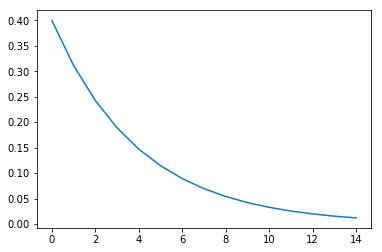

In [140]:
plt.plot(arr,kernel)
plt.show()

### Create fake data

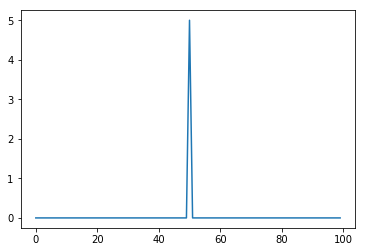

In [55]:
fakecolumn = np.zeros(100)
fakecolumn[50] = 5
plt.plot(fakecolumn)
plt.show()

### Brute force treatment

In [56]:
final = np.zeros(120)
print(fakecolumn.shape)

(100,)


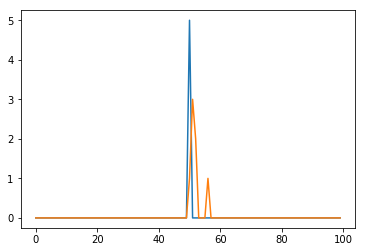

In [57]:
for i in range(len(final)-len(kernel)):
    final[i:i+len(kernel)] += np.random.poisson(fakecolumn[i]*kernel)
plt.plot(fakecolumn,label='Original')
plt.plot(final[:100],label='Convolved')
plt.show()

In [46]:
np.sum(kernel)

1.0165514795535835

## Application to images

crispy - INFO - Read data from HDU 1 of ../../../crispy/Inputs/os5_spc_064_targetstar_IFS.fits


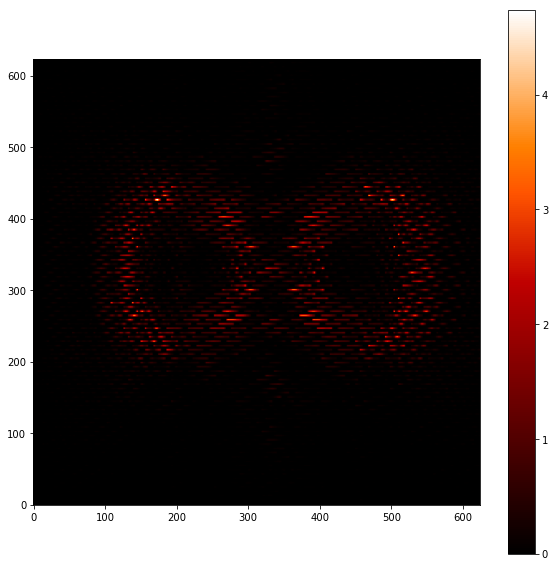

In [3]:
import sys
codefolder = '../../../../crispy'
if codefolder not in sys.path: sys.path.append(codefolder)
from crispy.tools.image import Image
img = Image('../../../crispy/Inputs/os5_spc_064_targetstar_IFS.fits')
img.data = img.data[200:-200,200:-200]
img.data*=1000

plt.figure(figsize=(10,10))
plt.imshow(img.data, cmap='gist_heat')
plt.colorbar()
plt.show()

### Seed random traps

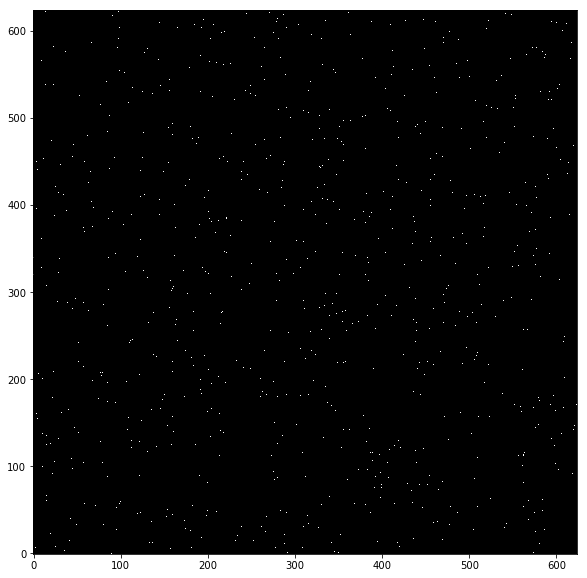

In [4]:
Ntraps = 1000
imgshape = img.data.shape
traps_X = np.random.randint(0,imgshape[0],Ntraps)
traps_Y = np.random.randint(0,imgshape[1],Ntraps)
#X,Y = np.meshgrid(traps_X.astype(int),traps_Y.astype(int))
traps = np.zeros(imgshape)
traps[traps_Y,traps_X] = 1
plt.figure(figsize=(10,10))
plt.imshow(traps, cmap='gist_heat')
plt.show()

### Assume that parallel register is on the top of the image (pixels have tail towards the bottom)

Go column by column

In [42]:


for icol in range(len(traps_X)):
    Xval = traps_X[icol]
    Yval = traps_Y[icol]
    data_column = img.data[:Yval,Xval]
    data_column = data_column[::-1]
    final = np.zeros(data_column.shape[0]+kernel.shape[0])
    for i in range(len(final)-len(kernel)):
        final[i:i+len(kernel)] += data_column[i]*kernel
    final = final[:-kernel.shape[0]]
    img.data[:Yval,Xval] = final[::-1]

out = np.random.poisson(img.data)
plt.figure(figsize=(20,20))
plt.imshow(out, cmap='gist_heat')
plt.colorbar()
plt.show()    

Image(data=out).write('../../code/SimResults/testTraps.fits',clobber=True)

crispy - INFO - Writing data to ../../code/SimResults/testNoTraps.fits


ValueError: operands could not be broadcast together with shapes (10,) (10,50) (10,) 

### Explore multiple traps along the same column

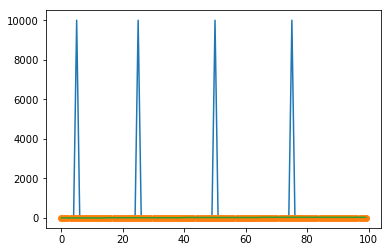

In [10]:
fakecolumn = np.zeros(100)
flux = 10000
fakecolumn[5] = flux
fakecolumn[25] = flux
fakecolumn[50] = flux
fakecolumn[75] = flux
traps = np.zeros(100)
traps[65] = 1
traps[40] = 1
traps[15] = 1
xarray = np.arange(len(fakecolumn))
plt.plot(xarray,fakecolumn)
plt.plot(xarray,traps,'o')
# how many traps are between a pixel and the register?
ntraps = np.cumsum(traps)
plt.plot(xarray,10*ntraps)
plt.show()

In [21]:
final = np.zeros(150)
kernel = np.zeros((10,50))
arr = np.arange(50)
for k in range(kernel.shape[0]):
    if k==0:
        kernel[k,0] = 1
    else:
        kernel[k] = np.exp(-0.5/k*arr)#0.5/k*np.exp(-0.5/k*arr)
    kernel[k] /= np.sum(kernel[k])


In [22]:
for i in range(kernel.shape[0]):
    print(np.sum(kernel[i]))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


/Users/mrizzo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


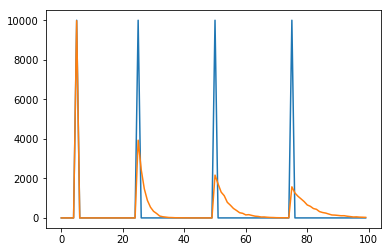

In [23]:
for i in range(len(final)-(kernel.shape[1])):
    final[i:i+kernel.shape[1]] += np.random.poisson(fakecolumn[i]*kernel[ntraps[i]])
plt.plot(fakecolumn,label='Original')
plt.plot(final[:100],label='Convolved')
plt.show()

crispy - INFO - Writing data to ../../code/SimResults/testNoTraps.fits


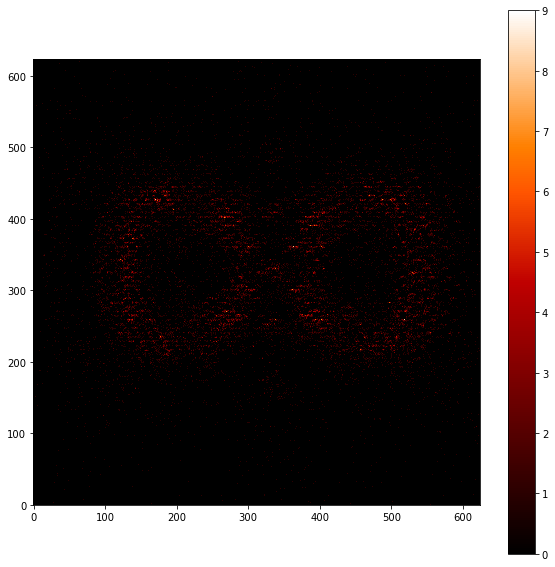

ImportError: No module named compare_mse

In [61]:
# traps = np.zeros(imgshape)
# traps[traps_Y,traps_X] = 1
testNoTraps = Image(data=np.random.poisson(img.data))
testNoTraps.write('../../code/SimResults/testNoTraps.fits',clobber=True)

imout = img.data.copy()
for icol in range(imout.shape[0]):
    Xval = traps_X[icol]
    ntraps = np.cumsum(traps[:,Xval])
    data_column = img.data[:,Xval]
    data_column = data_column[::-1]
    final = np.zeros(data_column.shape[0]+kernel.shape[1])
    
    # loop on all pixels within column
    for i in range(len(final)-(kernel.shape[1])):
        final[i:i+kernel.shape[1]] += data_column[i]*kernel[ntraps[i].astype(int)]
    final = final[:-kernel.shape[1]]
    imout[:,Xval] = final[::-1]

out = np.random.poisson(imout)
plt.figure(figsize=(10,10))
plt.imshow(out, cmap='gist_heat')
plt.colorbar()
plt.show()

testMultipleTraps = Image(data=out)
import skimage.measure.compare_mse as mse
import skimage.measure.compare_nrmse as nrmse
import skimage.measure.compare_ssim as ssim
s = ssim(testNoTraps.data, testMultipleTraps.data)
n = nrmse(testNoTraps.data, testMultipleTraps.data)
m = mse(testNoTraps.data, testMultipleTraps.data)
print(s,n,m)
testMultipleTraps.header.append(('comment', ''), end=True)
testMultipleTraps.header.append(('comment', '*'*60), end=True)
testMultipleTraps.header.append(('comment', '*'*22 + ' Compare between w/ and w/o traps ' + '*'*20), end=True)
testMultipleTraps.header.append(('comment', '*'*60), end=True)    
testMultipleTraps.header.append(('comment', ''), end=True)
testMultipleTraps.header.append(('SSIM',s,'Structural similarity index'),end=True)
testMultipleTraps.header.append(('MSE',m,'Mean squared error'),end=True)
testMultipleTraps.header.append(('NRMSE',m,'Normalized Root Mean squared error'),end=True)
testMultipleTraps.write('../../code/SimResults/testMultipleTraps.fits',clobber=True)

crispy - INFO - Read data from HDU 1 of ../../code/SimResults/testNoTraps.fits
crispy - INFO - Read data from HDU 1 of ../../code/SimResults/testMultipleTraps.fits


/Users/mrizzo/anaconda/lib/python2.7/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,


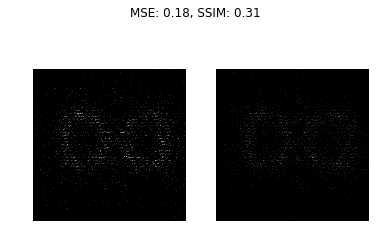

In [52]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err


from skimage.measure import structural_similarity as ssim

def compare_images(imageA, imageB, title):
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)

    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))

    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")

    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")

    # show the images
    plt.show()
    
img1 = Image('../../code/SimResults/testNoTraps.fits').data
img2 = Image('../../code/SimResults/testMultipleTraps.fits').data
compare_images(img1,img2,'Traps effects')

crispy - INFO - Read data from HDU 1 of ../../code/Inputs/os5_spc_064_targetstar_IFS.fits
4.735623952
